# Does GPT-3 "get" the joke?

*Sean Trott*

**Goal**: Determine whether GPT-3 is sensitive to humor manipulations, either in the form of `surprisal` or correctly responding to comprehension questions about the meaning of a joke.

Outline of code:

- Setup:  
- Part 1: Surprisals.
- Part 2: Comprehension. 


## Setup 

### Set up API

In [1]:
import openai
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import statsmodels.formula.api as smf

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [4]:
## Read in key
with open('gpt_key', 'r') as f:
    lines = f.read().split("\n")
org = lines[0]
api_key = lines[1]
openai.organization = org # org
openai.api_key = api_key # api_key

### Load data

In [5]:
df = pd.read_csv("data/raw/coulson_stimuli.csv")

In [6]:
df.head(5)

,Condition,Exp Code,Sentence,Answer,Correct,First Five Words,Group Number,Same/Different
0,J,1017,A committee keeps minutes and takes hours.,Committees are very efficient.,no,a committee keeps minutes and,1,Different
1,S,3017,A committee keeps minutes and takes votes.,Committees keep records and make decisions.,yes,a committee keeps minutes and,1,Different
2,S,4013,A device for finding furniture in the dark is ...,The candle gives off light.,yes,a device for finding furniture,2,Same
3,J,2013,A device for finding furniture in the dark is ...,People run into furniture when it's dark.,yes,a device for finding furniture,2,Same
4,E,6056,A good source of vitamin A is orange vegetable...,Carrots contain vitamin A.,yes,a good source of vitamin,3,E


## Part 1: Surprisals

In [7]:
import backoff  # for exponential backoff

In [8]:
@backoff.on_exception(backoff.expo, openai.error.RateLimitError)
def get_response(prompt, model, tokens = 0):
    response = openai.Completion.create(
        model=model,
        prompt=prompt,
        temperature=0,
        max_tokens=tokens, ### 0
        logprobs = 0,
        top_p=1,
        echo = True
    )
    
    return response

In [9]:
models = ['ada', 'babbage', 'curie', 'davinci', 
          'text-ada-001', 'text-babbage-001', 'text-curie-001', 'text-davinci-002']
# models = ['ada']

In [10]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    sentence = row['Sentence']
    
    ## Establish final word
    final_word = " " + sentence.replace(".", "").split()[-1]
    
    ## Establish num_tokens for final word
    num_tokens = len(get_response(final_word, "ada", tokens = 1).to_dict()['choices'][0]['logprobs']['tokens']) - 1
    
    for model in models:    
        
        ## Get responses
        response = get_response(sentence, model = model)
        
        ## Extract tokenized representation
        tokens = response.to_dict()['choices'][0]['logprobs']['tokens']
        identified_token = tokens[-2]
        
        ### Handle multi-token words
        if num_tokens > 1:
            identified_token = ''.join(tokens[-(num_tokens + 1):-1])
            log_prob = sum(response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-(num_tokens + 1):-1])
            if identified_token != final_word:
                print(tokens)
                print(num_tokens)
                print(final_word)
                print(identified_token)
        else:
            log_prob = response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-2]

        results.append({
            'sentence': sentence,
            'model': model,
            'condition': row['Condition'],
            'log_prob': log_prob,
            'num_tokens': num_tokens,
            'identified_token': identified_token,
            'surprisal': -log_prob,
            'final_word': final_word
        })
        
        

  0%|                                                   | 0/400 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [58]:
df_results = pd.DataFrame(results)

In [59]:
df_results.shape

(1172, 8)

In [47]:
(df_results['final_word'] == df_results['identified_token']).mean()

1.0

In [61]:
df_results.to_csv("data/processed/results_gpt.csv", index = False)

### Load data to analyze

In [10]:
df_results = pd.read_csv("data/processed/results_gpt.csv")

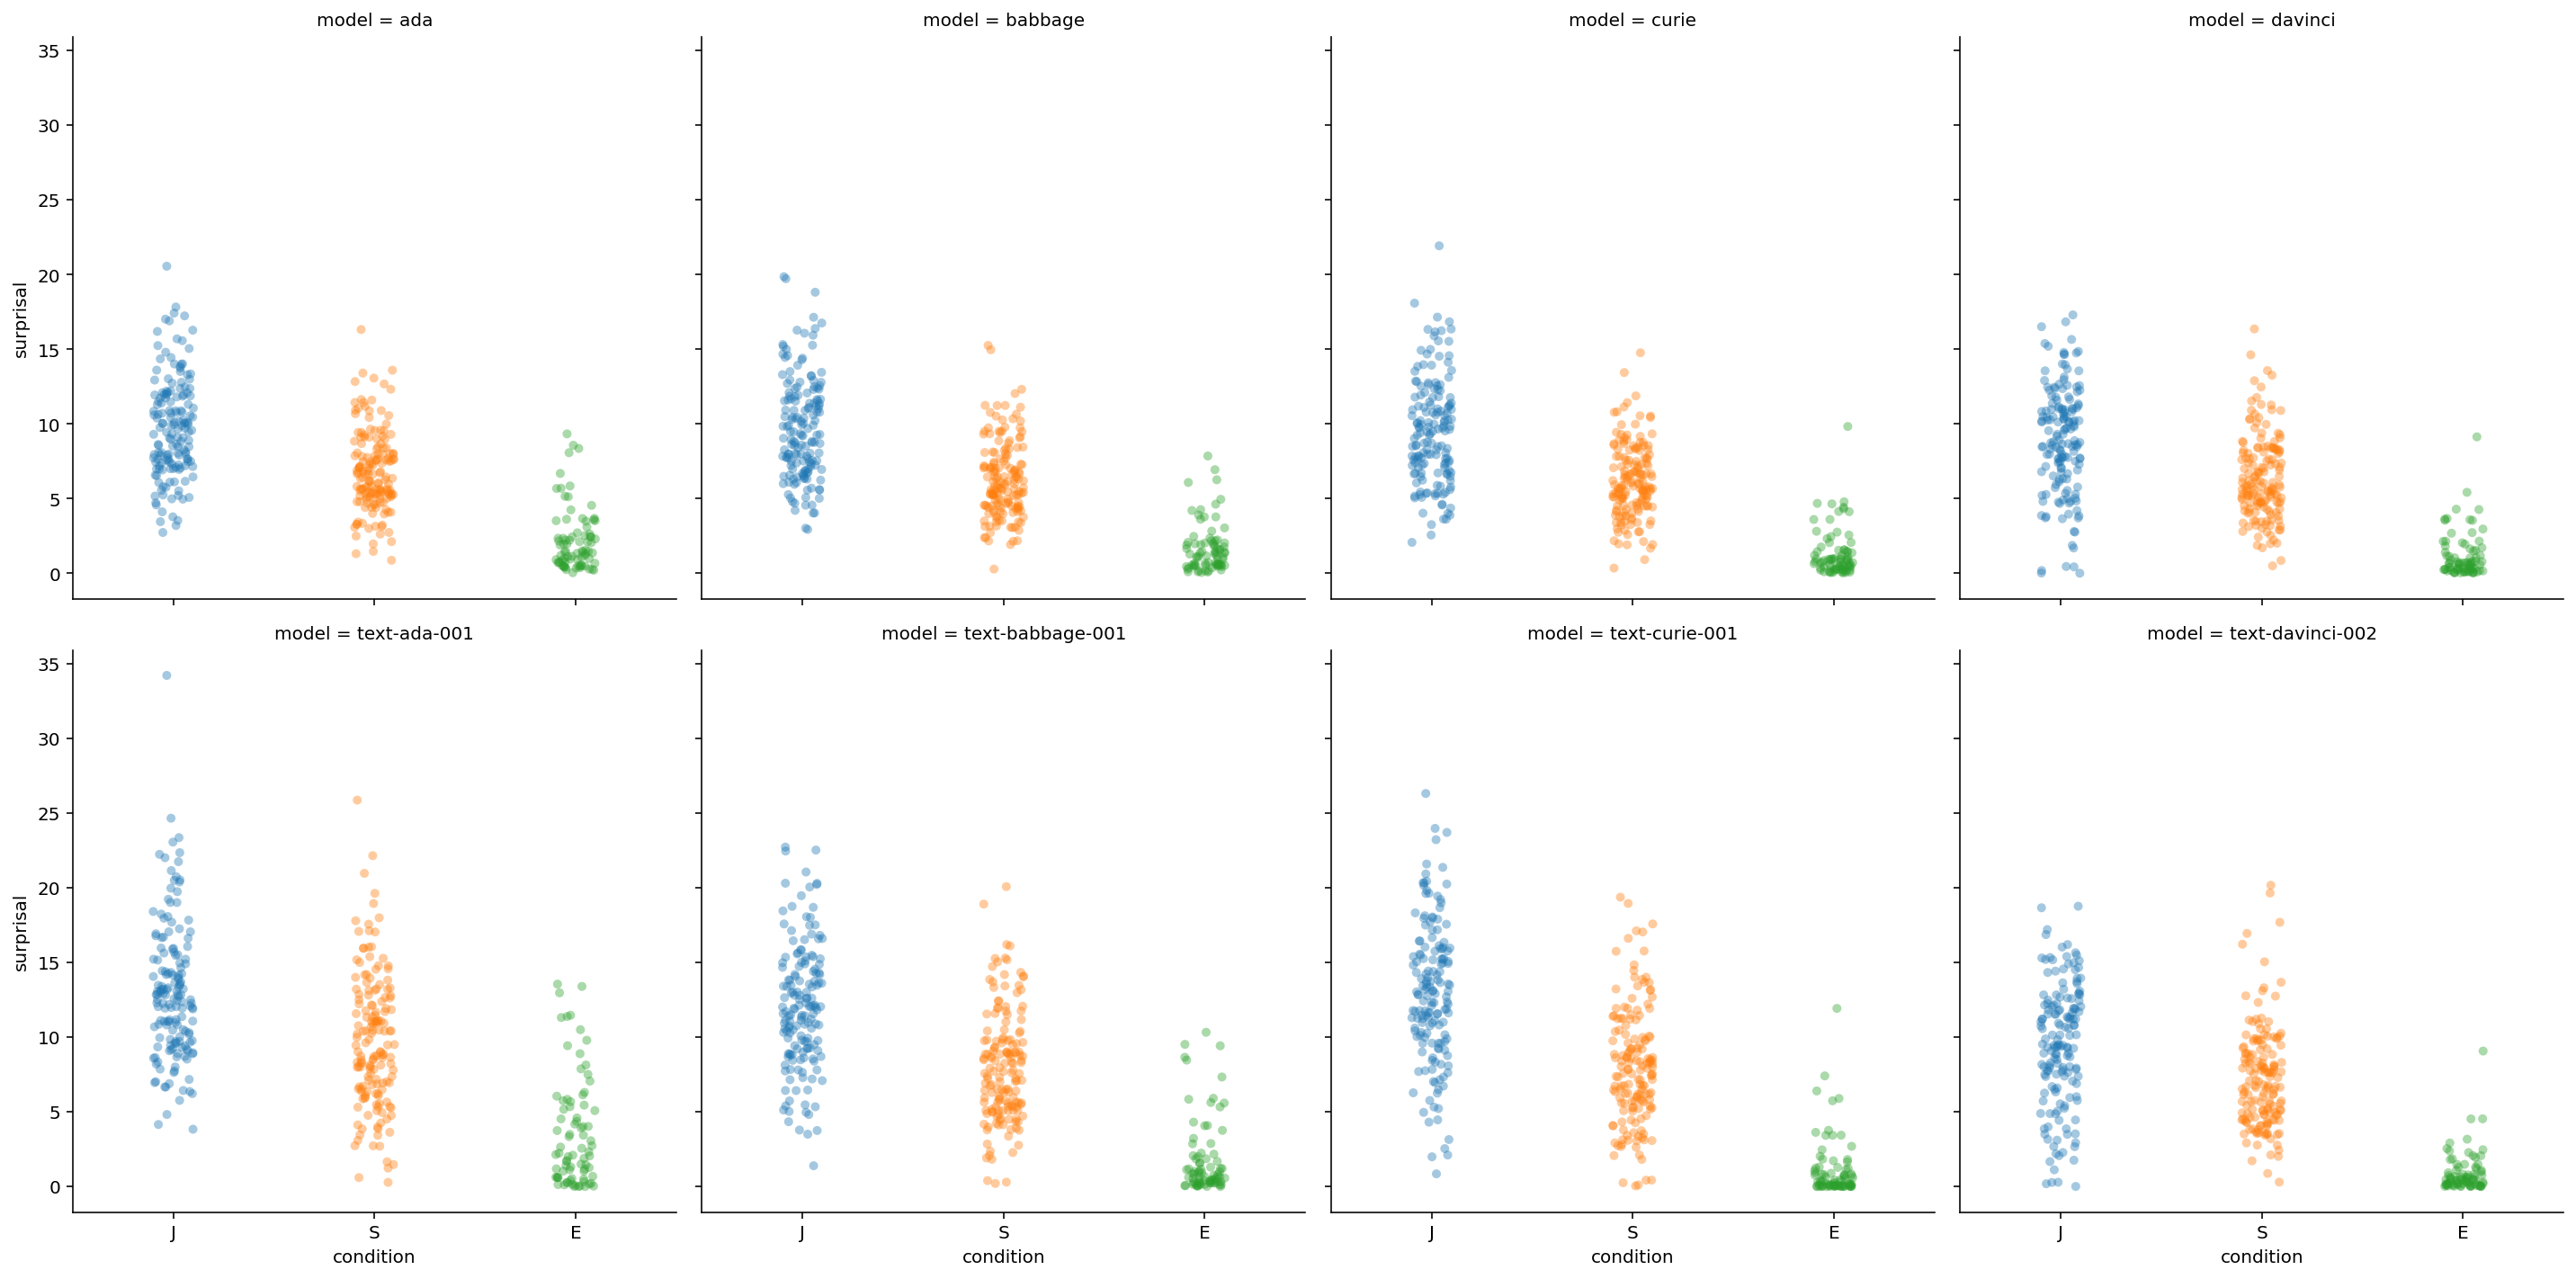

In [11]:
sns.catplot(data = df_results, x = 'condition', y = 'surprisal', 
            col = "model", col_wrap = 4, kind = "strip", alpha = .4)
plt.savefig("Figures/initial_results.png", dpi = 300)

In [15]:
params = [350000000, 1300000000, 6700000000, 175000000000,
         350000000, 1300000000, 6700000000, 175000000000]
text = [False, False, False, False, True, True, True, True]
df_params = pd.DataFrame({'model': models,
                         'params': params,
                         'text': text})

In [16]:
df_merged = pd.merge(df_params, df_results)

In [18]:
df_merged.to_csv("data/processed/results_gpt_with_params.csv", index = False)

In [52]:
mod = smf.ols(data = df_results[df_results['condition']!="E"],formula = "surprisal ~ condition").fit()


In [53]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              surprisal   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     75.90
Date:                Tue, 16 May 2023   Prob (F-statistic):           1.67e-16
Time:                        12:56:02   Log-Likelihood:                -807.48
No. Observations:                 320   AIC:                             1619.
Df Residuals:                     318   BIC:                             1626.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          9.8040      0.239     40.969      0.000       9.333      10.275
condition[T.S]    -2.9483      0.338     -8.712      0.000      -3.614      -2.282
==============================================================================
Omnibus:                       12.390   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.714
Skew:                           0.462   Prob(JB):                      0.00173
Kurtosis:                       3.314   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Part 2: Comprehension

In [10]:
with open("data/raw/instructions0shot.txt", "r") as f:
    instructions0shot = f.read()
print(instructions0shot)

In this task, you will be presented with a series of sentences. Some sentences will be serious statements, while others will be clever quips/jokes. In both cases your job is to determine whether the meaning of the second sentence is implied by the meaning of the first. If the two sentences have a similar meaning, answer "yes". If the two sentences do not have consistent meanings, answer "no".


In [11]:
with open("data/raw/instructions1shot.txt", "r") as f:
    instructions1shot = f.read()
print(instructions1shot)

In this task, you will be presented with a series of sentences. Some sentences will be serious statements, while others will be clever quips/jokes. In both cases your job is to determine whether the meaning of the second sentence is implied by the meaning of the first. If the two sentences have a similar meaning, answer "yes". If the two sentences do not have consistent meanings, answer "no".

Sentence 1: The heater kept it warm inside.
Sentence 2: It was cold in the house.

Does Sentence 2 match Sentence 1?

Answer: No.

Sentence 1: Our child has a great deal of willpower -- and even more won't power.
Sentence 2: Our child is very stubborn.

Does Sentence 2 match Sentence 1?

Answer: Yes.

Sentence 1: The teacher spoke while the students listened.
Sentence 2: The students joined in the conversation.

Does Sentence 2 match Sentence 1?

Answer: No.


In [12]:
def format_prompt(sentence, answer, prompt_shot, response):
    prompt = "{p}\n\nSentence 1: {x}\n\nSentence 2: {y}".format(
        p = prompt_shot, x = sentence, y = answer)
    prompt += "\n\nAnswer: {r}".format(r = response)
    return prompt

### 0-shot

In [58]:
models = ["text-davinci-002"]

In [59]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    sentence = row['Sentence']
    answer = row['Answer']
    
    yes_prompt = format_prompt(sentence, prompt_shot = instructions0shot, answer = answer, response = "Yes")
    no_prompt = format_prompt(sentence, prompt_shot = instructions0shot, answer = answer, response = "No")
    
    for model in models:

        ## Get responses
        yes_response = get_response(yes_prompt, model = model)
        no_response = get_response(no_prompt, model = model)
        
        ## Extract tokenized representations: YES
        yes_tokens = yes_response.to_dict()['choices'][0]['logprobs']['tokens']
        yes_identified_token = yes_tokens[-1]
        if yes_identified_token != " Yes":
            print(yes_identified_token) 
            
        ## Extract tokenized representations: NO
        no_tokens = no_response.to_dict()['choices'][0]['logprobs']['tokens']
        no_identified_token = no_tokens[-1]
        if no_identified_token != " No":
            print(no_identified_token)
        
        
        ## Get logprobs
        lp_yes = yes_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
        lp_no = no_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
            
        
        results.append({
            'model': model,
            'sentence': sentence,
            'answer': answer,
            'shots': 0, ### adjust with different runs
            'condition': row['Condition'],
            'correct': row['Correct'],
            'yes_lp': lp_yes, 
            'no_lp': lp_no
        })
            
        

100%|█████████████████████████████████████████| 400/400 [04:56<00:00,  1.35it/s]


In [60]:
df_results = pd.DataFrame(results)

In [61]:
df_results['lp_ratio'] = df_results['yes_lp'] - df_results['no_lp']

In [62]:
df_results.to_csv("data/processed/comprehension_probe_0shot.csv", index = False)

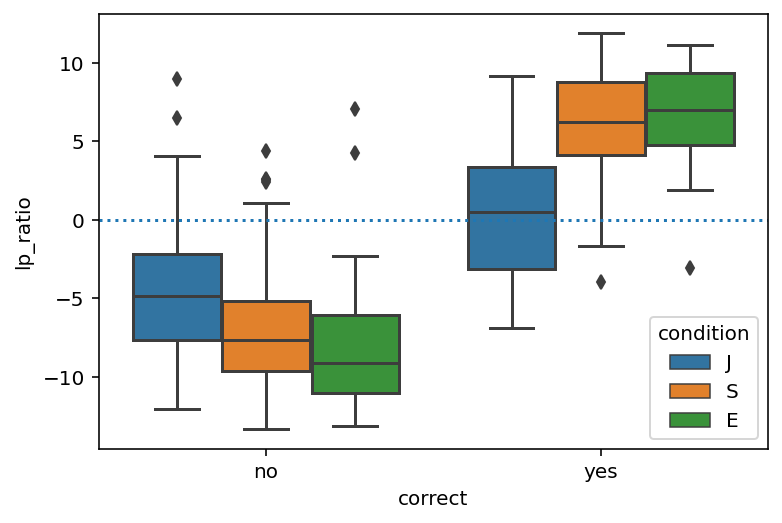

In [63]:
sns.boxplot(data = df_results, x = "correct", y = "lp_ratio", hue = "condition")
plt.axhline(y = 0, linestyle = "dotted")

In [64]:
def is_accurate(row):
    if row['correct'] == "yes":
        return row['lp_ratio'] > 0
    if row['correct'] == "no":
        return row['lp_ratio'] <= 0

In [65]:
df_results['accurate'] = df_results.apply(is_accurate, axis = 1)

In [66]:
df_results['accurate'].mean()

0.8425

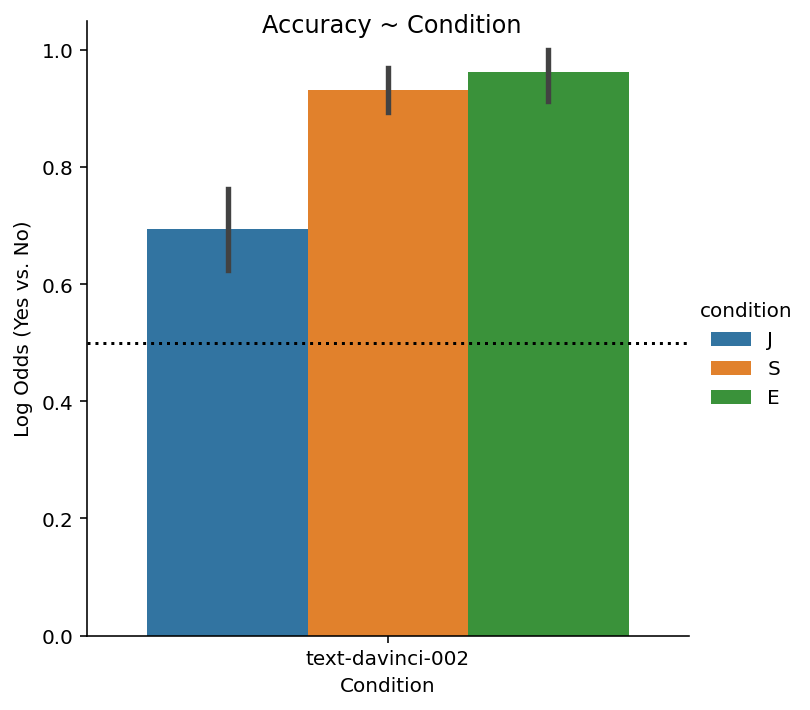

In [67]:
g = sns.catplot(data = df_results, x = "model", y = "accurate", hue = "condition", kind = "bar")

plt.axhline(y=0.5, linestyle='dotted', color='black')

# Set the title and labels
g.fig.suptitle('Accuracy ~ Condition')
g.set_xlabels('Condition')
g.set_ylabels('Log Odds (Yes vs. No)')

# plt.savefig("Figures/comprehension_probe.png", dpi = 300)

Text(0.5, 1.0, 'text-davinci-002 accuracy')

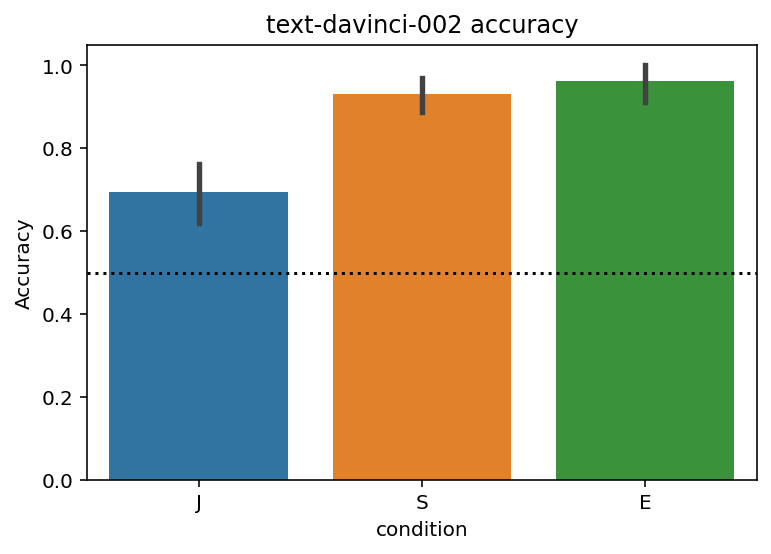

In [68]:
sns.barplot(data = df_results[df_results['model'] == "text-davinci-002"],
           x = "condition", y = "accurate")
plt.ylabel("Accuracy")
plt.axhline(y=0.5, linestyle='dotted', color='black')
plt.title("text-davinci-002 accuracy")

### 1-shot

In [14]:
models = ["text-davinci-002"]

In [15]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    sentence = row['Sentence']
    answer = row['Answer']
    
    yes_prompt = format_prompt(sentence, prompt_shot = instructions1shot, answer = answer, response = "Yes")
    no_prompt = format_prompt(sentence, prompt_shot = instructions1shot, answer = answer, response = "No")
    
    
    for model in models:

        ## Get responses
        yes_response = get_response(yes_prompt, model = model)
        no_response = get_response(no_prompt, model = model)
        
        ## Extract tokenized representations: YES
        yes_tokens = yes_response.to_dict()['choices'][0]['logprobs']['tokens']
        yes_identified_token = yes_tokens[-1]
        if yes_identified_token != " Yes":
            print(yes_identified_token) 
            
        ## Extract tokenized representations: NO
        no_tokens = no_response.to_dict()['choices'][0]['logprobs']['tokens']
        no_identified_token = no_tokens[-1]
        if no_identified_token != " No":
            print(no_identified_token)
        
        
        ## Get logprobs
        lp_yes = yes_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
        lp_no = no_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
            
        
        results.append({
            'model': model,
            'sentence': sentence,
            'answer': answer,
            'shots': 1, ### adjust with different runs
            'condition': row['Condition'],
            'correct': row['Correct'],
            'yes_lp': lp_yes, 
            'no_lp': lp_no
        })
            
        

100%|█████████████████████████████████████████| 400/400 [05:08<00:00,  1.30it/s]


In [16]:
df_results = pd.DataFrame(results)

In [17]:
df_results['lp_ratio'] = df_results['yes_lp'] - df_results['no_lp']

In [18]:
df_results.to_csv("data/processed/comprehension_probe_1shot.csv", index = False)

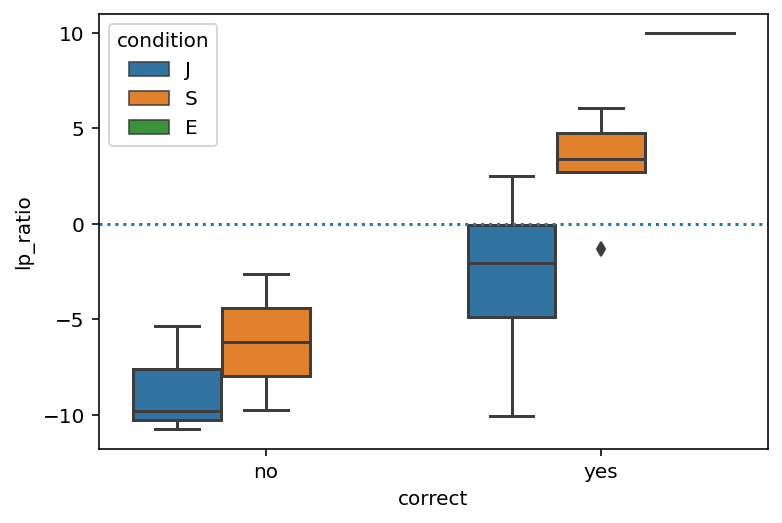

In [48]:
sns.boxplot(data = df_results, x = "correct", y = "lp_ratio", hue = "condition")
plt.axhline(y = 0, linestyle = "dotted")

## Supplementary: all models

In [21]:
models = ['ada', 'babbage', 'curie', 'davinci', 
          'text-ada-001', 'text-babbage-001', 'text-curie-001', 'text-davinci-002']

In [22]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    sentence = row['Sentence']
    answer = row['Answer']
    
    yes_prompt = format_prompt(sentence, prompt_shot = instructions0shot, answer = answer, response = "Yes")
    no_prompt = format_prompt(sentence, prompt_shot = instructions0shot, answer = answer, response = "No")
    
    for model in models:

        ## Get responses
        yes_response = get_response(yes_prompt, model = model)
        no_response = get_response(no_prompt, model = model)
        
        ## Extract tokenized representations: YES
        yes_tokens = yes_response.to_dict()['choices'][0]['logprobs']['tokens']
        yes_identified_token = yes_tokens[-1]
        if yes_identified_token != " Yes":
            print(yes_identified_token) 
            
        ## Extract tokenized representations: NO
        no_tokens = no_response.to_dict()['choices'][0]['logprobs']['tokens']
        no_identified_token = no_tokens[-1]
        if no_identified_token != " No":
            print(no_identified_token)
        
        
        ## Get logprobs
        lp_yes = yes_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
        lp_no = no_response.to_dict()['choices'][0]['logprobs']['token_logprobs'][-1]
            
        
        results.append({
            'model': model,
            'sentence': sentence,
            'answer': answer,
            'shots': 0, ### adjust with different runs
            'condition': row['Condition'],
            'correct': row['Correct'],
            'yes_lp': lp_yes, 
            'no_lp': lp_no
        })
            
        

100%|█████████████████████████████████████████| 400/400 [18:29<00:00,  2.77s/it]


In [23]:
df_results = pd.DataFrame(results)

In [24]:
df_results['lp_ratio'] = df_results['yes_lp'] - df_results['no_lp']

In [25]:
df_results.shape

(3200, 9)

In [26]:
df_results.to_csv("data/processed/all_models_comprehension_scaling_analysis.csv", index = False)

In [27]:
def is_accurate(row):
    if row['correct'] == "yes":
        return row['lp_ratio'] > 0
    if row['correct'] == "no":
        return row['lp_ratio'] <= 0

In [28]:
df_results['accurate'] = df_results.apply(is_accurate, axis = 1)

In [29]:
df_results['accurate'].mean()

0.55125

In [39]:
types = ['Base', 'Base', 'Base', 'Base', 'Instruct', 'Instruct', 'Instruct', 'Instruct']

In [40]:
len(types)

8

In [41]:
df_models = pd.DataFrame({
    'Model': models,
    'Model Type': types,
    'Parameters': [350000000, 1300000000, 6700000000, 175000000000,
                  350000000, 1300000000, 6700000000, 175000000000]
})

In [43]:
df_models.to_csv("data/processed/model_params.csv", index=False)

<AxesSubplot:xlabel='accurate', ylabel='model'>

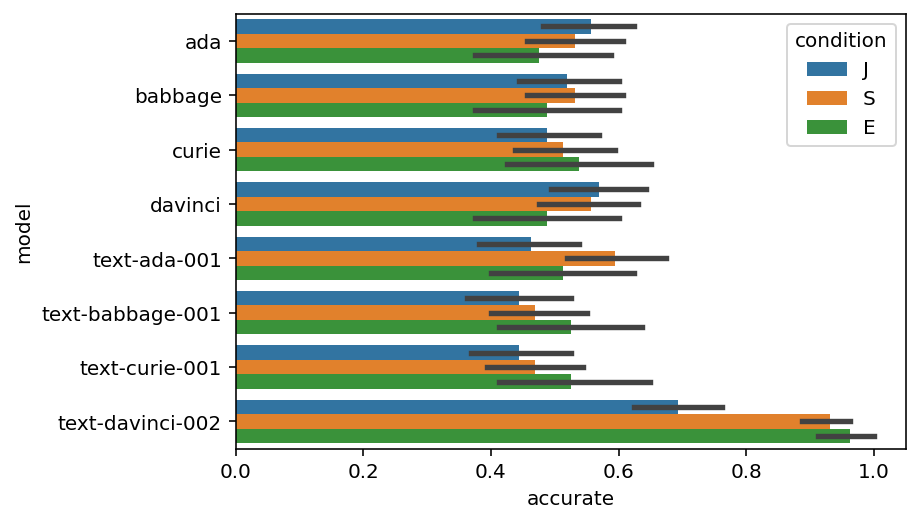

In [46]:
sns.barplot(data = df_results, y = "model", x = "accurate", hue = 'condition')

## GPT-4

In [35]:
def format_prompt_gpt4(sentence, answer, prompt_shot):
    prompt = "{p}\n\nSentence 1: {x}\n\nSentence 2: {y}".format(
        p = prompt_shot, x = sentence, y = answer)
    prompt += "\n\nAnswer: "
    return prompt

In [36]:
@backoff.on_exception(backoff.expo, openai.error.RateLimitError)
def pred_tokens(prompt, n=10, model="gpt-4"):
    """Get response."""
    output = openai.ChatCompletion.create(
        model = model,
        temperature = 0,
        messages=[
                {"role": "system", "content": "You are a helpful assistant. Your job is to figure out which sentences follow logically from which other sentences."},
                {"role": "user", "content": prompt}
            ],
      max_tokens=3,
      top_p=1
        )

    return output# output['choices'][0]['message']['content']

In [38]:
answers = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    sentence = row['Sentence']
    answer = row['Answer']
    
    prompt = format_prompt_gpt4(sentence, prompt_shot = instructions0shot, answer = answer)
    
    response = pred_tokens(prompt)
    extracted_response = response['choices'][0]['message']['content']

    answers.append({'response': extracted_response,
                    'word': sentence,
                   'answer': answer})
    


100%|█████████████████████████████████████████| 400/400 [05:16<00:00,  1.26it/s]


In [54]:
df_answers = pd.DataFrame(answers)

In [58]:
df_answers['correct'] = df['Correct']
df_answers['response_lower'] = df_answers['response'].str.lower()
df_answers['condition'] = df['Condition']

In [59]:
(df_answers['response'].str.lower() == df_answers['correct']).mean()

0.885

In [60]:
df_answers.to_csv("data/processed/gpt4_comprehension.csv", index=False)